In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [2]:
mnist = Path('/storage/data/mnist_png')
mnist.ls()

(#2) [Path('/storage/data/mnist_png/training'),Path('/storage/data/mnist_png/testing')]

In [3]:
# Convert all images in a directory to [0,1] tensors and stack them
def stackImages( path ):
    return torch.stack([tensor(Image.open(o)) for o in path.ls()]).float()/255

In [4]:
def loadStacks( path ):
    stacks = torch.cat([stackImages(folder) for folder in path.ls()])
    labels = [tensor([int(folder.name)]*len(folder.ls())) for folder in (mnist/'training').ls()]
    return list(zip(stacks.view(-1,28*28), nn.functional.one_hot(torch.cat(labels))))

In [5]:
def getLoaders( path, batch_size=256 ):
    train = DataLoader( loadStacks(path/'training'), batch_size, shuffle=True )
    valid = DataLoader( loadStacks(path/'testing'), batch_size, shuffle=True  )
    return train, valid

In [6]:
train_dl, valid_dl = getLoaders( mnist )

In [7]:
dls = DataLoaders(train_dl, valid_dl)
dls

In [8]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,10),
    nn.Softmax(dim=1)
)

In [9]:
printDebug = True

In [10]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [11]:
def batch_accuracy(xb, yb):
    temp = (xb.argmax(1) == yb.argmax(1)).float()
    if( printDebug == True ):
        print( f'batch acurracy: {temp.sum()}/{len(yb)} = {temp.mean()}')
    return temp.mean()

In [12]:
batch = dls.one_batch()

Make sure the data and label are lining up properly

(<AxesSubplot:>, tensor(8))

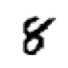

In [13]:
show_image(batch[0][1].view(28,28)), batch[1][1].argmax(-1)

Try our accuracy function before training

In [14]:
batch_accuracy( simple_net(batch[0]), batch[1] )

batch acurracy: 24.0/256 = 0.09375


tensor(0.0938)

Manually compare the first batch to get an idea of how things are looking

In [15]:
simple_net( batch[0] ).argmax(1),batch[1].argmax(1)

(tensor([0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 0, 7, 7, 0, 7, 7, 7, 0, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 0,
         7, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 0, 7, 7, 0, 7, 0, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 7, 7, 7, 0, 7, 0, 7, 7, 0, 7, 7, 7, 7, 7, 0, 7, 7, 7, 0, 7, 3, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 0, 0, 7, 0, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 3, 0, 0, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0]),
 tensor([7, 8, 1, 8, 5, 2, 6, 1, 3, 8, 2, 1, 0, 5, 5, 2, 2, 2, 6, 6, 9, 8, 0, 0, 4, 2, 7, 6, 3, 5, 0, 6, 7, 4, 1, 1, 1, 2, 2, 7, 1, 1, 1, 3, 5, 4, 1, 7, 2, 2, 8, 3, 2, 1, 2, 9, 6, 3, 8, 8, 2, 8,

I was unable to find the proper syntax to use a BasicOptimizer instead of SGD so i'm not able to debug what's happening in SGD. My uneducated guess is that back propagation changes aren't being saved for some reason

In [16]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=2.7542285919189453)

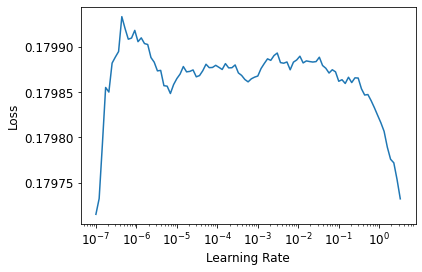

In [17]:
lr = learn.lr_find()
lr

Run a few learning steps, batch accuracy has a debug statement printing each result, this can be disabled with the following:

In [18]:
#printDebug = False

In [19]:
learn.fit(4,lr.lr_steep)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.052997,0.198727,0.006100,00:02
1,0.038955,0.199070,0.004700,00:01
2,0.035937,0.199330,0.003300,00:01
3,0.034542,0.199190,0.003800,00:01


batch acurracy: 2.0/256 = 0.0078125
batch acurracy: 2.0/256 = 0.0078125
batch acurracy: 3.0/256 = 0.01171875
batch acurracy: 0.0/256 = 0.0
batch acurracy: 3.0/256 = 0.01171875
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 3.0/256 = 0.01171875
batch acurracy: 0.0/256 = 0.0
batch acurracy: 0.0/256 = 0.0
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 4.0/256 = 0.015625
batch acurracy: 2.0/256 = 0.0078125
batch acurracy: 3.0/256 = 0.01171875
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 0.0/256 = 0.0
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 2.0/256 = 0.0078125
batch acurracy: 2.0/256 = 0.0078125
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 2.0/256 = 0.0078125
batch acurracy: 0.0/256 = 0.0
batch acurracy: 3.0/256 = 0.01171875
batch acurracy: 3.0/256 = 0.01171875
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 0.0/256 = 0.0
batch acurracy: 0.0/256 = 0.0
batch acurracy: 2.0/2

So according to that run, batch accuracy was very bad, but if we manually calculate our accuracy again, the accuracy shoots up seemingly showing that simple_net's parameters improved even though the learning loop didn't reflect that

In [20]:
batch_accuracy( simple_net(batch[0]), batch[1] )

batch acurracy: 215.0/256 = 0.83984375


tensor(0.8398)

In [21]:
simple_net( batch[0] ).argmax(1),batch[1].argmax(1)

(tensor([7, 8, 1, 8, 5, 2, 6, 1, 0, 8, 2, 1, 0, 5, 5, 2, 2, 2, 6, 6, 1, 8, 0, 0, 4, 2, 7, 6, 3, 3, 0, 6, 7, 4, 1, 1, 1, 2, 2, 7, 1, 1, 1, 3, 5, 4, 1, 7, 2, 2, 8, 3, 2, 1, 2, 7, 6, 3, 8, 8, 2, 8, 5, 6,
         3, 7, 0, 7, 1, 7, 1, 4, 6, 4, 1, 5, 2, 8, 6, 8, 1, 6, 7, 2, 0, 7, 3, 7, 1, 2, 1, 7, 8, 4, 3, 2, 3, 0, 4, 1, 3, 6, 5, 4, 6, 0, 2, 7, 4, 4, 6, 3, 7, 3, 7, 4, 4, 6, 6, 5, 1, 0, 8, 6, 4, 0, 1, 8,
         1, 6, 3, 3, 4, 3, 6, 1, 7, 7, 2, 5, 8, 3, 2, 8, 5, 4, 6, 1, 6, 7, 1, 2, 8, 5, 2, 5, 1, 0, 2, 5, 5, 3, 1, 0, 4, 3, 4, 0, 4, 2, 6, 5, 6, 7, 1, 2, 1, 2, 5, 3, 7, 2, 4, 2, 7, 4, 0, 6, 4, 6, 2, 7,
         2, 0, 4, 5, 5, 7, 5, 8, 6, 3, 2, 7, 0, 0, 4, 5, 2, 7, 8, 0, 5, 0, 7, 6, 1, 3, 3, 7, 7, 8, 5, 5, 0, 1, 4, 2, 3, 7, 7, 2, 5, 7, 3, 8, 5, 7, 1, 8, 7, 3, 5, 0, 7, 3, 3, 4, 0, 4, 0, 2, 4, 3, 6, 6]),
 tensor([7, 8, 1, 8, 5, 2, 6, 1, 3, 8, 2, 1, 0, 5, 5, 2, 2, 2, 6, 6, 9, 8, 0, 0, 4, 2, 7, 6, 3, 5, 0, 6, 7, 4, 1, 1, 1, 2, 2, 7, 1, 1, 1, 3, 5, 4, 1, 7, 2, 2, 8, 3, 2, 1, 2, 9, 6, 3, 8, 8, 2, 8,

Learn still doesn't reflect the improvement though

In [22]:
learn.fit(1,lr.lr_steep)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.034108,0.199311,0.003200,00:01


batch acurracy: 2.0/256 = 0.0078125
batch acurracy: 0.0/256 = 0.0
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 2.0/256 = 0.0078125
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 0.0/256 = 0.0
batch acurracy: 2.0/256 = 0.0078125
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 0.0/256 = 0.0
batch acurracy: 0.0/256 = 0.0
batch acurracy: 0.0/256 = 0.0
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 0.0/256 = 0.0
batch acurracy: 3.0/256 = 0.01171875
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 0.0/256 = 0.0
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 0.0/256 = 0.0
batch acurracy: 0.0/256 = 0.0
batch acurracy: 0.0/256 = 0.0
batch acurracy: 0.0/256 = 0.0
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 0.0/256 = 0.0
batch acurracy: 2.0/256 = 0.0078125
batch acurracy: 2.0/256 = 0.0078125
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 1.0/256 = 0.00390625
batch acurracy: 

Resetting the model to show the accuracy dropping back to default

In [23]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,10),
    nn.Softmax(dim=1)
)

In [24]:
batch_accuracy( simple_net(batch[0]), batch[1] )

batch acurracy: 28.0/256 = 0.109375


tensor(0.1094)